In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import time, os
from IPython.display import clear_output
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Input Pipeline

As mentioned in the paper, apply random jittering and mirroring to the training dataset. These are some of the image augmentation techniques that avoids overfitting.



*   In random jittering, the image is resized to 286 x 286 and then randomly cropped to 256 x 256.
*   In random mirroring, the image is randomly flipped horizontally i.e left to right.

## Datasets

In [ ]:
BUFFER_SIZE = 1000
MAX_SIZE = BUFFER_SIZE+100
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

**download**
* Login/Signup into kaggle account 
* Go to account -> API configuration
* Download the `kaggle.json` file 
* Lunch the following block and upload it

In [ ]:
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

# human faces
!kaggle datasets download -d xhlulu/flickrfaceshq-dataset-nvidia-resized-256px
!unzip flickrfaceshq-dataset-nvidia-resized-256px -d faces_dataset
!rm flickrfaceshq-dataset-nvidia-resized-256px.zip

dir_x = '/content/faces_dataset/resized/'

In [ ]:
# simpson faces
!kaggle datasets download -d kostastokis/simpsons-faces
!unzip simpsons-faces -d simpson_dataset
!rm simpsons-faces.zip

dir_y = '/content/simpson_dataset/cropped/'

In [ ]:
# animal faces
!kaggle datasets download -d andrewmvd/animal-faces
!unzip animal-faces -d animal_dataset
!rm animal-faces.zip

dir_y = '/content/animal_dataset/afhq/train/wild/'

In [ ]:
# bitmoji faces
!kaggle datasets download -d mostafamozafari/bitmoji-faces
!unzip bitmoji-faces -d bitmoji_dataset
!rm bitmoji-faces.zip

dir_y = '/content/bitmoji_dataset/BitmojiDataset/images/'

**create train and test data**

In [ ]:
images_x, images_y = [], []

for filename in os.listdir(dir_x):
  img = tf.keras.preprocessing.image.load_img(dir_x+filename)
  img = img.resize((IMG_WIDTH, IMG_HEIGHT))
  arr = tf.keras.preprocessing.image.img_to_array(img)
  images_x.append(arr)
  if len(images_x) > MAX_SIZE: break

for filename in os.listdir(dir_y):
  img = tf.keras.preprocessing.image.load_img(dir_y+filename)
  img = img.resize((IMG_WIDTH, IMG_HEIGHT))
  arr = tf.keras.preprocessing.image.img_to_array(img)
  images_y.append(arr)
  if len(images_y) > MAX_SIZE: break

train_x = tf.data.Dataset.from_tensor_slices(images_x[:BUFFER_SIZE+1])
test_x = tf.data.Dataset.from_tensor_slices(images_x[BUFFER_SIZE:MAX_SIZE+1])
del images_x

train_y = tf.data.Dataset.from_tensor_slices(images_y[:BUFFER_SIZE+1])
test_y = tf.data.Dataset.from_tensor_slices(images_y[BUFFER_SIZE:MAX_SIZE+1])
del images_y

## Preprocessing

In [ ]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [ ]:
def random_crop(image):
  cropped_image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
  return cropped_image

In [ ]:
def random_flip(image):
  image = tf.image.random_flip_left_right(image)
  return image

In [ ]:
def random_jitter(image, resize=True):
  
  if resize:
    # resizing
    image = tf.image.resize(image, [IMG_WIDTH+int(IMG_WIDTH/8), IMG_HEIGHT+int(IMG_HEIGHT/8)], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # randomly cropping
    image = random_crop(image)

  else:
    image = tf.image.resize(image, [IMG_WIDTH, IMG_HEIGHT], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
  # random mirroring
  image = random_flip(image)

  return image

In [ ]:
def preprocess_image_train(image):
  image = random_jitter(image)
  image = normalize(image)
  return image

def preprocess_image_train_noresize(image):
  image = random_jitter(image, resize=False)
  image = normalize(image)
  return image

def preprocess_image_test(image):
  image = tf.image.resize(image, [IMG_WIDTH, IMG_HEIGHT], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  image = normalize(image)
  return image

In [ ]:
train_x = train_x.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE
    ).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train_y = train_y.map(
    preprocess_image_train_noresize, num_parallel_calls=AUTOTUNE
    ).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_x = test_x.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE
    ).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_y = test_y.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE
    ).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
sample_x = next(iter(train_x))
sample_y = next(iter(train_y))

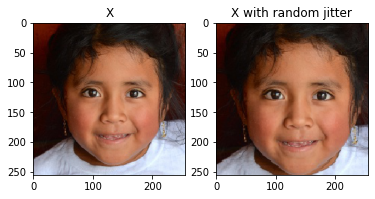

In [ ]:
plt.subplot(121)
plt.title('X')
plt.imshow(sample_x[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('X with random jitter')
plt.imshow(random_jitter(sample_x[0]) * 0.5 + 0.5)

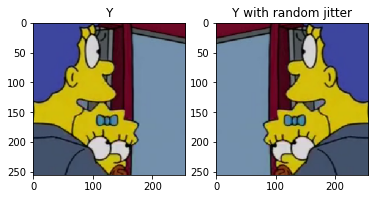

In [ ]:
plt.subplot(121)
plt.title('Y')
plt.imshow(sample_y[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Y with random jitter')
plt.imshow(random_jitter(sample_y[0], resize=False) * 0.5 + 0.5)

# CycleGan

## Layers

Define the encoder/decoder blocks for down/up sample the images and the Instance Normalization (instead of Batch Normalization) following the paper https://arxiv.org/abs/1703.10593

### Instance Normalization

https://arxiv.org/abs/1607.08022

In [ ]:
class InstanceNormalization(tf.keras.layers.Layer):

  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset

### Encoder

(Conv -> InstanceNorm -> Leaky ReLU)

In [ ]:
def downsample(filters, size, strides=2, apply_batchnorm=True, leaky=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  layers = tf.keras.Sequential()
  layers.add(tf.keras.layers.Conv2D(filters, size, strides=strides, 
                                    padding='same', 
                                    kernel_initializer=initializer, 
                                    use_bias=False))

  if apply_batchnorm:
    layers.add(InstanceNormalization())

  if leaky:
    layers.add(tf.keras.layers.LeakyReLU())
  else:
    layers.add(tf.keras.layers.ReLU())

  return layers

### Transformer

(Convolution Residual Block = Conv2D -> Conv2D)

In [ ]:
def resblock(filters, size):
  initializer = tf.random_normal_initializer(0., 0.02)

  layers = tf.keras.Sequential()
  layers.add(tf.keras.layers.Conv2D(filters, size, strides=1, 
                                    padding='same', 
                                    kernel_initializer=initializer, 
                                    use_bias=False))
  layers.add(InstanceNormalization())
  layers.add(tf.keras.layers.ReLU())
  
  layers.add(tf.keras.layers.Conv2D(filters, size, strides=1, 
                                    padding='same', 
                                    kernel_initializer=initializer, 
                                    use_bias=False))
  layers.add(InstanceNormalization())
  
  return layers

### Decoder

(Transposed Conv -> InstanceNorm -> Dropout -> ReLU)

In [ ]:
def upsample(filters, size, strides=2, activation='relu', apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  layers = tf.keras.Sequential()
  layers.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=strides,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  layers.add(InstanceNormalization())

  if apply_dropout:
      layers.add(tf.keras.layers.Dropout(0.5))

  if activation == 'relu':
    layers.add(tf.keras.layers.ReLU())
  elif activation == 'tanh':
    layers.add(tf.keras.layers.Activation('tanh'))

  return layers

## Generator

2 generator models:
* Pix2Pix model (unet generator)
* CycleGan model (resnet generator: encoder -> transformer -> decoder)

In [ ]:
#Pix2Pix Model from Tensorflow Guide ---NOT USED---
def Generator():
  inputs = tf.keras.layers.Input(shape=[IMG_WIDTH,IMG_HEIGHT,3])

  down_stack = [
    downsample(64, 7, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(3, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
#CycleGan Model from paper
def Generator():
  inputs = tf.keras.layers.Input(shape=[IMG_WIDTH,IMG_HEIGHT,3])

  encoder = [
    downsample(64, 7, strides=1), # (bs, 256, 256, 64)
    downsample(128, 3), # (bs, 128, 128, 128)
    downsample(256, 3)  # (bs, 64, 64, 256)
  ]

  transformer = [
    resblock(256, 3), # (bs, 64, 64, 256)
    resblock(256, 3), # (bs, 64, 64, 256)
    resblock(256, 3), # (bs, 64, 64, 256)
    resblock(256, 3), # (bs, 64, 64, 256)
    resblock(256, 3), # (bs, 64, 64, 256)
    resblock(256, 3), # (bs, 64, 64, 256)
    resblock(256, 3), # (bs, 64, 64, 256)
    resblock(256, 3), # (bs, 64, 64, 256)
    resblock(256, 3)  # (bs, 64, 64, 256)
  ]

  decoder = [
    upsample(128, 3), # (bs, 128, 128, 128)
    upsample(64, 3), # (bs, 256, 256, 64)
    upsample(3, 7, strides=1, activation='tanh') # (bs, 256, 256, 3)
  ]

  x = inputs

  # Downsampling
  for down in encoder:
    x = down(x)

  # Residual connections
  for res in transformer:
    r = res(x)
    x = tf.keras.layers.Concatenate()([r, x])

  # Upsampling
  for up in decoder:
    x = up(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
#generator = Generator()
#tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

## Discriminator

PatchGan discriminator model (https://arxiv.org/abs/1611.07004)

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  x = tf.keras.layers.Input(shape=[IMG_WIDTH,IMG_HEIGHT,3], name='input_image')
  inp = x

  down1 = downsample(64, 4, apply_batchnorm=False, leaky=True)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4, leaky=True)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4, leaky=True)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  norm1 = InstanceNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=inp, outputs=last)

In [ ]:
#discriminator = Discriminator()
#tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

There are 2 generators (G and F) and 2 discriminators (X and Y)

 

*   Generator G learns to transform image X to image Y.
*   Generator F learns to transform image Y to image X.
*   Discriminator D_X learns to differentiate between image X and generated image X (F(Y)).
*   Discriminator D_Y learns to differentiate between image Y and generated image Y (G(X)).


 



In [ ]:
generator_g = Generator()
generator_f = Generator()

discriminator_x = Discriminator()
discriminator_y = Discriminator()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


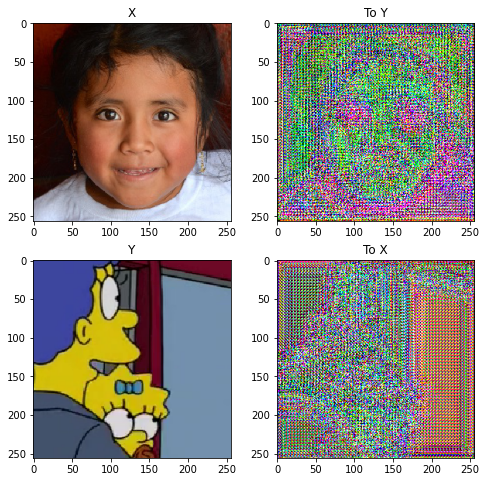

In [ ]:
to_y = generator_g(sample_x)
to_x = generator_f(sample_y)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_x, to_y, sample_y, to_x]
title = ['X', 'To Y', 'Y', 'To X']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

## Loss


In [ ]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

cycle loss:

*   Image $X$ is passed via generator $G$ that yields generated image $\hat Y$.
*   Generated image $\hat Y$ is passed via generator $F$ that yields cycled image $\hat X$.
*   Mean absolute error is calculated between $X$ and $\hat X$.

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

Feeding image $Y$ to generator $G$, should yield the real image $Y$ or something close



In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

# Training

**Optimizers**

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Image Generator

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

## Step

In [ ]:
@tf.function
def train_step(real_x, real_y):
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))
  
  return total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss

**Checkpoints**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive_path = "/content/drive/My Drive/AIRO/V&P/Project"

Mounted at /content/drive


In [ ]:
checkpoint_path = drive_path+"/checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

Latest checkpoint restored!!


## Loop

In [ ]:
EPOCHS = 8
DECAY = 2e-4/100 '''FROM EPOCHS 100 to 200 lr decreases linearly'''

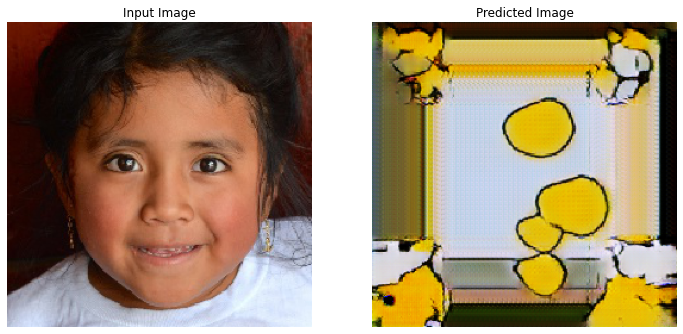

Losses:
	Generator G = 10.79376220703125
	Generator F = 10.379962921142578
	Discriminator X = 0.1752001941204071
	Discriminator Y = 0.14063973724842072

Time taken for epoch 7 is 1288.6588442325592 sec

............................................

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()
  if (DECAY != 0):
    generator_g_optimizer.lr.assign_sub(DECAY)
    generator_f_optimizer.lr.assign_sub(DECAY)
    
  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_x, train_y)):
    gg_loss, gf_loss, dx_loss, dy_loss = train_step(image_x, image_y)
    if n % 10 == 0:
      print('.', end='')
    n+=1

  clear_output(wait=True)
  generate_images(generator_g, sample_x)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))

  print('Losses:\n\tGenerator G = {}\n\tGenerator F = {}\n\tDiscriminator X = {}\n\tDiscriminator Y = {}\n'
  .format(gg_loss, gf_loss, dx_loss, dy_loss))
  print('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

# Test

In [ ]:
for x in test_x.take(10):
  generate_images(generator_g, x)

Output hidden; open in https://colab.research.google.com to view.